In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import json
import copy

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

import annotation, image_render, hyspec_io, hyspec_ml, batch_process, misc

In [2]:
# Paths
hyspec_dir = "/media/mha114/Massimal/Bodo_Sandsund/Hyperspectral/20210602/Area/3b_R_rs_GeoRef"
annotation_json = "/media/mha114/Massimal/Bodo_Sandsund/Hyperspectral/20210602/Area/M_Annotation/label_classes.json"
annotation_train_dir = "/media/mha114/Massimal/Bodo_Sandsund/Hyperspectral/20210602/Area/M_Annotation/Training"
annotation_val_dir = "/media/mha114/Massimal/Bodo_Sandsund/Hyperspectral/20210602/Area/M_Annotation/Validation"

annotation_train_pickle = "/media/mha114/Massimal/Bodo_Sandsund/Hyperspectral/20210602/Area/M_Annotation/TrainingData.pickle"

In [3]:
# Read class dictionary
class_dict = annotation.read_hasty_metadata(annotation_json)
class_dict

{'Zostera marina, healthy, dominant': 1,
 'Zostera marina, healthy, common': 2,
 'Zostera marina, healthy, sparse': 3,
 'Zostera marina, partly dead, with periphyton, dominant': 4,
 'Zostera marina, partly dead, with periphyton, common': 5,
 'Zostera marina, partly dead, with periphyton, sparse': 6,
 'Zostera marina, dead, with periphyton, dominant': 7,
 'Zostera marina, dead, with periphyton, common': 8,
 'Zostera marina, dead, with periphyton, sparse': 9,
 'Turf algae, dominant': 10,
 'Turf algae, common': 11,
 'Turf algae, sparse': 12,
 'Sand': 13,
 'Green algae': 14,
 'Rockweed': 15,
 'Blue mussel patches': 16}

In [4]:
# Define classes that can be merged
classes_to_merge = [
    [
        'Zostera marina, healthy, dominant',
        'Zostera marina, healthy, common',
        'Zostera marina, healthy, sparse'
    ],
    [
        'Zostera marina, partly dead, with periphyton, dominant',
        'Zostera marina, partly dead, with periphyton, common',
        'Zostera marina, partly dead, with periphyton, sparse'
    ],
    [
        'Zostera marina, dead, with periphyton, dominant',
        'Zostera marina, dead, with periphyton, common',
        'Zostera marina, dead, with periphyton, sparse'
    ],
    [
        'Turf algae, dominant',
        'Turf algae, common',
        'Turf algae, sparse'
    ]
]

merged_class_names = [
    'Zostera marina, healthy',
    'Zostera marina, partly dead',
    'Zostera marina, dead',
    'Turf algae'
]

In [5]:
# Collect training data
# data = batch_process.collect_annotated_data(class_dict, hyspec_dir, annotation_train_dir)

Processing file: Sandsund_May2021_Pika_L_11
Opening file /media/mha114/Massimal/Bodo_Sandsund/Hyperspectral/20210602/Area/3b_R_rs_GeoRef/Sandsund_May2021_Pika_L_11-Radiance From Raw Data-Reflectance from Radiance Data and Downwelling Irradiance Spectrum-Georectify Airborne Datacube.bip.hdr
Processing file: Sandsund_May2021_Pika_L_12
Opening file /media/mha114/Massimal/Bodo_Sandsund/Hyperspectral/20210602/Area/3b_R_rs_GeoRef/Sandsund_May2021_Pika_L_12-Radiance From Raw Data-Reflectance from Radiance Data and Downwelling Irradiance Spectrum-Georectify Airborne Datacube.bip.hdr
Processing file: Sandsund_May2021_Pika_L_15
Opening file /media/mha114/Massimal/Bodo_Sandsund/Hyperspectral/20210602/Area/3b_R_rs_GeoRef/Sandsund_May2021_Pika_L_15-Radiance From Raw Data-Reflectance from Radiance Data and Downwelling Irradiance Spectrum-Georectify Airborne Datacube.bip.hdr
Processing file: Sandsund_May2021_Pika_L_17
Opening file /media/mha114/Massimal/Bodo_Sandsund/Hyperspectral/20210602/Area/3b_R_

In [6]:
# Save data to disk
# misc.pickle_save_data(data,annotation_train_pickle)

In [7]:
# Load data
# data = misc.pickle_load_data(annotation_train_pickle)

In [8]:
# Describe / explore data structure
print('Data is a list with ' + str(len(data)) + ' elements, each of which represents an image.')
print('Each element in the list is a dictionary with the following keys: \n')
for key in data[0].keys():
    print(key)

print('\nThe first "hyspec_file" is')
print(data[0]['hyspec_file'])
print('\nThe "spectra" dict element is another dict with class names as keys:')
for key in data[0]['spectra'].keys():
    print(key)

print('\nThe shape of one of the "spectra" elements is')    
print(data[0]['spectra']['Zostera marina, partly dead, with periphyton, common'].shape)
print('This shows that each "spectra" element is a matrix with samples along 1. dim and spectral channels along 2. dim')

Data is a list with 12 elements, each of which represents an image.
Each element in the list is a dictionary with the following keys: 

hyspec_file
annotation_file
nonzero_mask
annotation_mask
wavelength
rgb_ind
spectra

The first "hyspec_file" is
/media/mha114/Massimal/Bodo_Sandsund/Hyperspectral/20210602/Area/3b_R_rs_GeoRef/Sandsund_May2021_Pika_L_11-Radiance From Raw Data-Reflectance from Radiance Data and Downwelling Irradiance Spectrum-Georectify Airborne Datacube.bip.hdr

The "spectra" dict element is another dict with class names as keys:
Zostera marina, healthy, dominant
Zostera marina, healthy, common
Zostera marina, healthy, sparse
Zostera marina, partly dead, with periphyton, dominant
Zostera marina, partly dead, with periphyton, common
Zostera marina, partly dead, with periphyton, sparse
Zostera marina, dead, with periphyton, dominant
Zostera marina, dead, with periphyton, common
Zostera marina, dead, with periphyton, sparse
Turf algae, dominant
Turf algae, common
Turf alga

In [9]:
# filename = os.path.split(data[10]['hyspec_file'])[1]
# print(filename)
# print('L_5' not in filename)
# print('L_6' not in filename)

In [66]:
# Extract wavelength vector from data structure
wl = data[0]['wavelength']

In [67]:
# Find total number of spectra in data
n_samp = 0
for element in data:
    for class_name in element['spectra'].keys():
        n_samp += element['spectra'][class_name].shape[0]
n_spec = element['spectra'][class_name].shape[1]

In [68]:
# Preallocate X and y
X = np.zeros((n_samp,n_spec))
y = np.zeros(n_samp)

In [69]:
# Loop over all images and insert spectra into X and y
ind = 0
for element in data:
    for class_name in element['spectra'].keys():
        n_samp_loc = element['spectra'][class_name].shape[0]

        X[ind:(ind + n_samp_loc),:] = element['spectra'][class_name]
        y[ind:(ind + n_samp_loc)] = class_dict[class_name]
        
        ind = ind + n_samp_loc

In [70]:
# Limit wavelength range (less noisy data)
wl_ind = (wl >= 400) & (wl <= 900)
X = X[:,wl_ind]
wl = wl[wl_ind]


In [71]:
(class_dict_merged, y_merged) = annotation.merge_classes_in_label_vector(
        class_dict,y,classes_to_merge,merged_class_names)

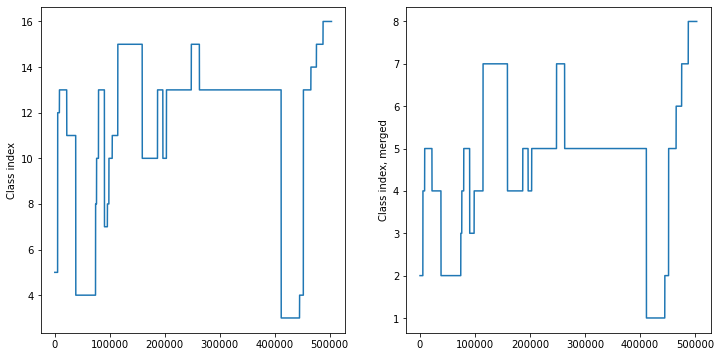

In [72]:
# fig, ax = plt.subplots(1,2) 
fig, ax = plt.subplots(ncols=2,figsize=(12,6))

ax[0].plot(y)
ax[0].set_ylabel('Class index')
ax[1].plot(y_merged)
ax[1].set_ylabel('Class index, merged')
plt.draw()

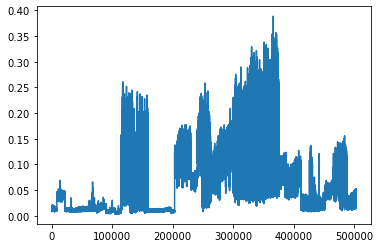

In [73]:
plt.plot(X[:,100])

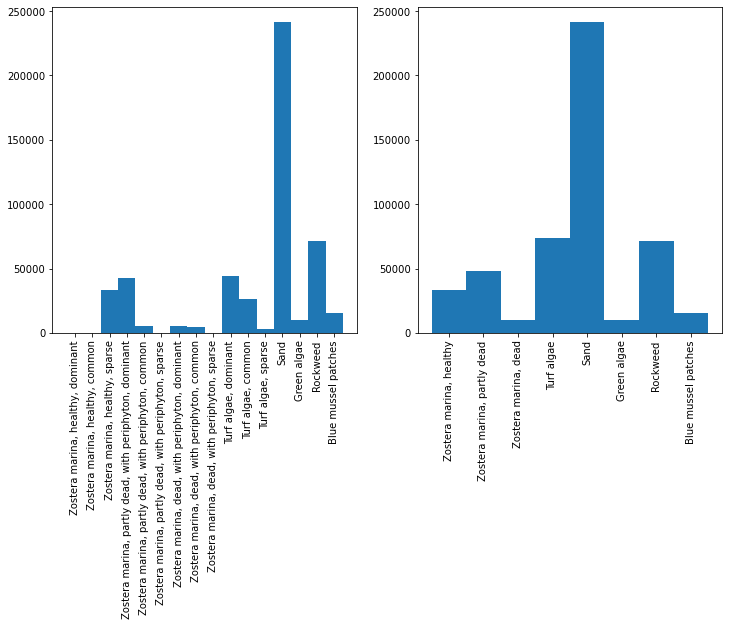

In [74]:
# Show histogram of number of class samples

class_name_list = [key for key in class_dict.keys()]
class_name_merged_list = [key for key in class_dict_merged.keys()]

fig, ax = plt.subplots(ncols=2,figsize=(12,6))
# fig, ax = plt.subplots(1,1) 
# ax.plot(x,y)

ax[0].hist(y,bins = np.arange(0,len(class_dict)+1)+0.5)
ax[0].set_xticks(np.arange(1,len(class_dict)+1))
ax[0].set_xticklabels(class_name_list, rotation='vertical')

ax[1].hist(y_merged,bins = np.arange(0,len(class_dict_merged)+1)+0.5)
ax[1].set_xticks(np.arange(1,len(class_dict_merged)+1))
ax[1].set_xticklabels(class_name_merged_list, rotation='vertical')

plt.draw()

The histograms show that in the original annotation, there are several empty classes, and some classes have very few samples. After merging classes, there are no empty classes, but there is still some imbalance. The most striking imbalance is that that the "sand" class is overrepresented. 

In [75]:
strategy = {class_dict_merged['Sand']:75000}
rus = RandomUnderSampler(random_state=0, sampling_strategy=strategy)

X_resampled, y_resampled = rus.fit_resample(X, y_merged)

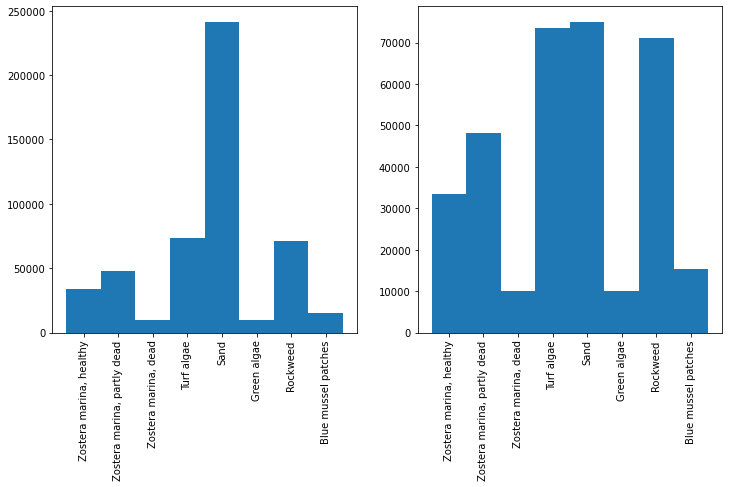

In [76]:
# Show histogram of number of class samples before/after undersampling sand

fig, ax = plt.subplots(ncols=2,figsize=(12,6))

ax[0].hist(y_merged,bins = np.arange(0,len(class_dict_merged)+1)+0.5)
ax[0].set_xticks(np.arange(1,len(class_dict_merged)+1))
ax[0].set_xticklabels(class_name_merged_list, rotation='vertical')

ax[1].hist(y_resampled,bins = np.arange(0,len(class_dict_merged)+1)+0.5)
ax[1].set_xticks(np.arange(1,len(class_dict_merged)+1))
ax[1].set_xticklabels(class_name_merged_list, rotation='vertical')

plt.draw()

In [77]:
#%% Scaling and PCA model
scaler = StandardScaler()
X_sc = scaler.fit_transform(X_resampled)

pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_sc)

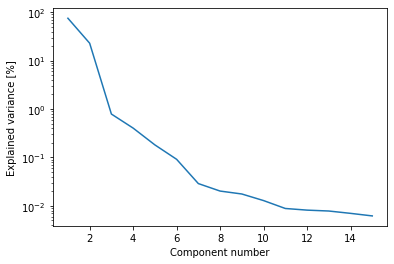

In [78]:
#%% Plot explained variance
plt.semilogy(np.arange(pca.n_components)+1, pca.explained_variance_ratio_*100)
plt.xlabel('Component number')
plt.ylabel('Explained variance [%]')
plt.show()

Based on the shape of explained variance, we can see an inflection point at around component number 7. 

In [79]:
n_comp_incl = 7
print('Including ' + str(n_comp_incl) + ' components yields total explained variance: ')
print(str(np.sum(pca.explained_variance_ratio_[0:n_comp_incl])*100) + ' %')

n_comp_incl = 15
print('Including ' + str(n_comp_incl) + ' components yields total explained variance: ')
print(str(np.sum(pca.explained_variance_ratio_[0:n_comp_incl])*100) + ' %')

Including 7 components yields total explained variance: 
99.63684430715074 %
Including 15 components yields total explained variance: 
99.72560691328447 %


Based on this we're choosing 7 or 8 components.

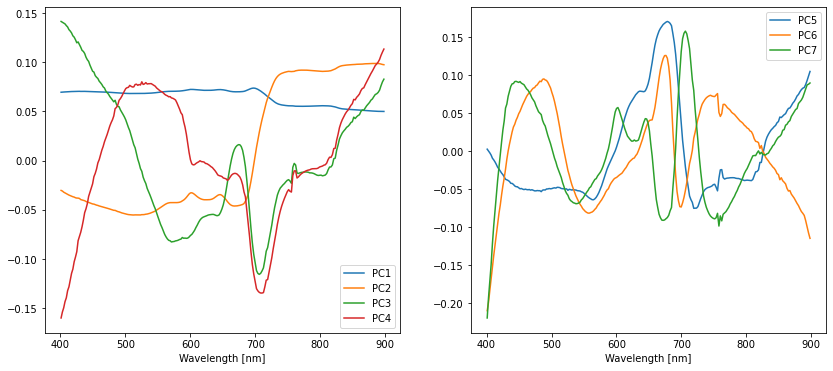

In [82]:
#%% Plot first components vs. wavelength
fig,ax = plt.subplots(ncols=2,figsize=(14,6))
ax[0].plot(wl,pca.components_[0,:],label='PC1')
ax[0].plot(wl,pca.components_[1,:],label='PC2')
ax[0].plot(wl,pca.components_[2,:],label='PC3')
ax[0].plot(wl,pca.components_[3,:],label='PC4')
ax[0].set_xlabel('Wavelength [nm]')
ax[0].legend()

ax[1].plot(wl,pca.components_[4,:],label='PC5')
ax[1].plot(wl,pca.components_[5,:],label='PC6')
ax[1].plot(wl,pca.components_[6,:],label='PC7')
# ax[1].plot(wl,pca.components_[7,:],label='PC8')
ax[1].set_xlabel('Wavelength [nm]')
ax[1].legend()

plt.show()

In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)

In [129]:
#%% Create pipeline for feature normalization, PCA and classification
clf = make_pipeline(StandardScaler(),PCA(n_components=7), RandomForestClassifier(n_estimators=100)) 

In [130]:
# Fit classifier
clf.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=7)),
                ('randomforestclassifier', RandomForestClassifier())])

In [131]:
y_pred = clf.predict(X_test)

In [132]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred,
                            labels = [value for value in class_dict_merged.values()],
                            target_names=[key for key in class_dict_merged.keys()]))

                             precision    recall  f1-score   support

    Zostera marina, healthy       0.78      0.87      0.82      9956
Zostera marina, partly dead       0.98      0.97      0.98     14258
       Zostera marina, dead       0.98      0.97      0.97      2935
                 Turf algae       1.00      1.00      1.00     22117
                       Sand       0.99      0.99      0.99     22647
                Green algae       0.95      0.88      0.91      3052
                   Rockweed       0.98      0.99      0.98     21437
        Blue mussel patches       0.69      0.53      0.60      4631

                   accuracy                           0.95    101033
                  macro avg       0.92      0.90      0.91    101033
               weighted avg       0.95      0.95      0.95    101033



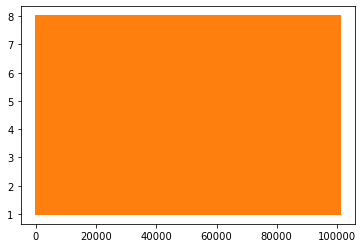

In [120]:
plt.plot(y_test)
plt.plot(y_pred)

In [133]:
from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(y_test, y_pred,normalize='true')
cm = confusion_matrix(y_test, y_pred,normalize=None)

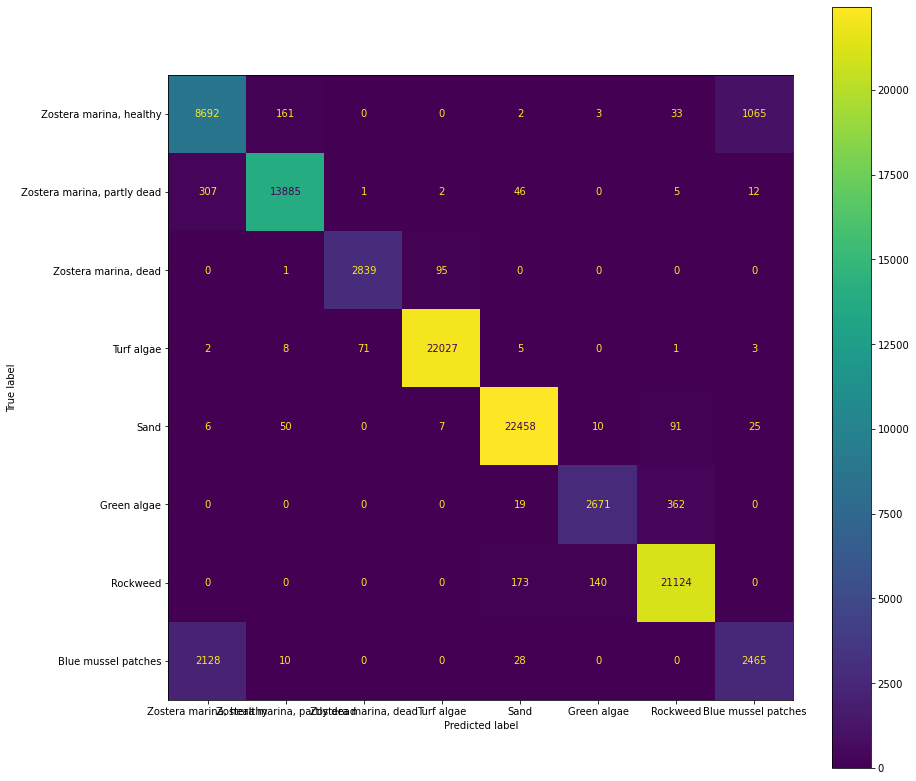

In [134]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(cm, display_labels=[key for key in class_dict_merged.keys()])

fig,ax = plt.subplots(ncols=1,figsize=(14,14))
disp.plot(ax=ax)